## Setting up the Working Directory
This cell is to ensure we change the directory to anomalib source code to have access to the datasets and config files. We assume that you already went through `001_getting_started.ipynb` and install the required packages.

In [3]:
!cp -r /scratch/ssenth21/warmup_ex_contd/autoencoder_img /scratch/ssenth21/anomalib/datasets/autoencoder_img

In [16]:
import os
from pathlib import Path



current_directory = Path.cwd()
if current_directory.name == "100_datamodules":
    # On the assumption that, the notebook is located in
    #   ~/anomalib/notebooks/100_datamodules/
    root_directory = current_directory.parent.parent
elif current_directory.name == "anomalib":
    # This means that the notebook is run from the main anomalib directory.
    root_directory = current_directory
else:
    pass
    #from git.repo import Repo
    # Otherwise, we'll need to clone the anomalib repo to the `current_directory`
    #repo = Repo.clone_from(url="https://github.com/openvinotoolkit/anomalib.git", to_path=current_directory)
    #root_directory = current_directory / "anomalib"

#root_directory = "/scratch/ssenth21/warmup_ex_contd/"
os.chdir(root_directory)
print(root_directory)
#folder_dataset_root = "/scratch/ssenth21/warmup_ex_contd/autoencoder_img"
folder_dataset_root = root_directory / "datasets" / "autoencoder_img"
print(folder_dataset_root)

/scratch/ssenth21/anomalib
/scratch/ssenth21/anomalib/datasets/autoencoder_img


## Use Folder Dataset (for Custom Datasets) via API

Here we show how one can utilize custom datasets to train anomalib models. A custom dataset in this model can be of the following types:

- A dataset with good and bad images.
- A dataset with good and bad images as well as mask ground-truths for pixel-wise evaluation.
- A dataset with good and bad images that is already split into training and testing sets.

To experiment this setting we provide a toy dataset that could be downloaded from the following [https://github.com/openvinotoolkit/anomalib/blob/main/docs/source/data/hazelnut_toy.zip](link). For the rest of the tutorial, we assume that the dataset is downloaded and extracted to `../../datasets`, located in the `anomalib` directory.

In [2]:
# pylint: disable=wrong-import-position, wrong-import-order
# flake8: noqa
import numpy as np
from PIL import Image
from torchvision.transforms import ToPILImage

from anomalib.data.folder import Folder, FolderDataset
from anomalib.data.utils import InputNormalizationMethod, get_transforms

### DataModule

Similar to how we created the datamodules for existing benchmarking datasets in the previous tutorials, we can also create an Anomalib datamodule for our custom hazelnut dataset.

In addition to the root folder of the dataset, we now also specify which folder contains the normal images, which folder contains the anomalous images, and which folder contains the ground truth masks for the anomalous images.


In [17]:
Folder??

Init signature:
Folder(
    normal_dir: 'str | Path',
    root: 'str | Path | None' = None,
    abnormal_dir: 'str | Path | None' = None,
    normal_test_dir: 'str | Path | None' = None,
    mask_dir: 'str | Path | None' = None,
    normal_split_ratio: 'float' = 0.2,
    extensions: 'tuple[str] | None' = None,
    image_size: 'int | tuple[int, int] | None' = None,
    center_crop: 'int | tuple[int, int] | None' = None,
    normalization: 'str | InputNormalizationMethod' = <InputNormalizationMethod.IMAGENET: 'imagenet'>,
    train_batch_size: 'int' = 32,
    eval_batch_size: 'int' = 32,
    num_workers: 'int' = 8,
    task: 'TaskType' = <TaskType.SEGMENTATION: 'segmentation'>,
    transform_config_train: 'str | A.Compose | None' = None,
    transform_config_eval: 'str | A.Compose | None' = None,
    test_split_mode: 'TestSplitMode' = <TestSplitMode.FROM_DIR: 'from_dir'>,
    test_split_ratio: 'float' = 0.2,
    val_split_mode: 'ValSplitMode' = <ValSplitMode.FROM_TEST: 'from_test'>,
    

In [3]:
folder_datamodule = Folder(
    root=folder_dataset_root,
    normal_dir="normal200",
    abnormal_dir="flip",
    task="segmentation",
    image_size=256,
    normalization=InputNormalizationMethod.NONE,  # don't apply normalization, as we want to visualize the images
)
folder_datamodule.setup()

In [4]:
# Train images
i, data = next(enumerate(folder_datamodule.train_dataloader()))
print(data.keys(), data["image"].shape)

dict_keys(['image_path', 'label', 'image', 'mask_path', 'mask']) torch.Size([32, 3, 256, 256])


In [6]:
# Test images
i, data = next(enumerate(folder_datamodule.test_dataloader()))
print(data.keys(), data["image"].shape)

[ WARN:0@81.237] global loadsave.cpp:244 findDecoder imread_(''): can't open/read file: check file path/integrity


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ssenth21/.conda/envs/anomalib_env/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ssenth21/.conda/envs/anomalib_env/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ssenth21/.conda/envs/anomalib_env/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/scratch/ssenth21/anomalib/src/anomalib/data/base/dataset.py", line 133, in __getitem__
    mask = cv2.imread(mask_path, flags=0) / 255.0
TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'


As can be seen above, creating the dataloaders are pretty straghtforward, which could be directly used for training/testing/inference. We could visualize samples from the dataloaders as well.

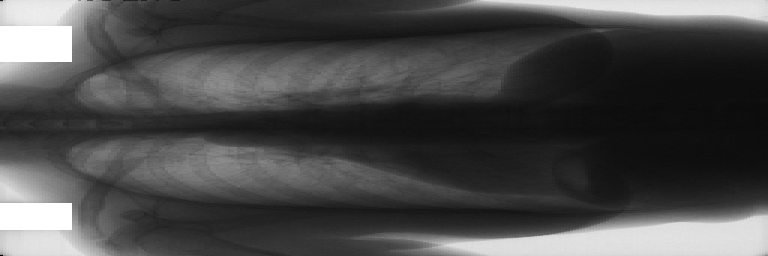

In [8]:
img = ToPILImage()(data["image"][0].clone())

Image.fromarray(np.hstack((np.array(img))))

`Folder` data module offers much more flexibility cater all different sorts of needs. Please refer to the documentation for more details.

### Torch Dataset

As in earlier examples, we can also create a standalone PyTorch dataset instance.

In [9]:
FolderDataset??

Init signature: FolderDataset(*args, **kwds)
Source:        
class FolderDataset(AnomalibDataset):
    """Folder dataset.
    Args:
        task (TaskType): Task type. (``classification``, ``detection`` or ``segmentation``).
        transform (A.Compose): Albumentations Compose object describing the transforms that are applied to the inputs.
        split (str | Split | None): Fixed subset split that follows from folder structure on file system.
            Choose from [Split.FULL, Split.TRAIN, Split.TEST]
        normal_dir (str | Path): Path to the directory containing normal images.
        root (str | Path | None): Root folder of the dataset.
        abnormal_dir (str | Path | None, optional): Path to the directory containing abnormal images.
        normal_test_dir (str | Path | None, optional): Path to the directory containing
            normal images for the test dataset. Defaults to None.
        mask_dir (str | Path | None, optional): Path to the directory containing
        

To create `FolderDataset` we need to create the albumentations object that applies transforms to the input image.

In [10]:
get_transforms??

Signature:
get_transforms(
    config: 'str | A.Compose | None' = None,
    image_size: 'int | tuple[int, int] | None' = None,
    center_crop: 'int | tuple[int, int] | None' = None,
    normalization: 'InputNormalizationMethod' = <InputNormalizationMethod.IMAGENET: 'imagenet'>,
    to_tensor: 'bool' = True,
) -> 'A.Compose'
Source:   
def get_transforms(
    config: str | A.Compose | None = None,
    image_size: int | tuple[int, int] | None = None,
    center_crop: int | tuple[int, int] | None = None,
    normalization: InputNormalizationMethod = InputNormalizationMethod.IMAGENET,
    to_tensor: bool = True,
) -> A.Compose:
    """Get transforms from config or image size.

    Args:
        config (str | A.Compose | None, optional): Albumentations transforms.
            Either config or albumentations ``Compose`` object. Defaults to None.
        image_size (int | tuple | None, optional): Image size to transform. Defaults to None.
        to_tensor (bool, optional): Boolean to conver

In [11]:
image_size = (256, 256)
transform = get_transforms(image_size=256, normalization=InputNormalizationMethod.NONE)

#### Classification Task

In [12]:
folder_dataset_classification_train = FolderDataset(
    normal_dir=folder_dataset_root / "normal200",
    abnormal_dir=folder_dataset_root / "flip",
    split="train",
    transform=transform,
    task="classification",
)
folder_dataset_classification_train.setup()
folder_dataset_classification_train.samples.head()

,image_path,label,label_index,mask_path,split
0,/scratch/ssenth21/anomalib/datasets/autoencode...,normal,0,,train
1,/scratch/ssenth21/anomalib/datasets/autoencode...,normal,0,,train
2,/scratch/ssenth21/anomalib/datasets/autoencode...,normal,0,,train
3,/scratch/ssenth21/anomalib/datasets/autoencode...,normal,0,,train
4,/scratch/ssenth21/anomalib/datasets/autoencode...,normal,0,,train


Let's look at the first sample in the dataset.

In [13]:
data = folder_dataset_classification_train[0]
print(data.keys(), data["image"].shape)

dict_keys(['image_path', 'label', 'image']) torch.Size([3, 256, 256])


As can be seen above, when we choose `classification` task and `train` split, the dataset only returns `image`. This is mainly because training only requires normal images and no labels. Now let's try `test` split for the `classification` task

In [14]:
# Folder Classification Test Set
folder_dataset_classification_test = FolderDataset(
    normal_dir=folder_dataset_root / "normal",
    abnormal_dir=folder_dataset_root / "flip",
    split="test",
    transform=transform,
    task="classification",
)
folder_dataset_classification_test.setup()
folder_dataset_classification_test.samples.head()

,image_path,label,label_index,mask_path,split
0,/scratch/ssenth21/anomalib/datasets/autoencode...,abnormal,1,,test
1,/scratch/ssenth21/anomalib/datasets/autoencode...,abnormal,1,,test
2,/scratch/ssenth21/anomalib/datasets/autoencode...,abnormal,1,,test
3,/scratch/ssenth21/anomalib/datasets/autoencode...,abnormal,1,,test
4,/scratch/ssenth21/anomalib/datasets/autoencode...,abnormal,1,,test


In [15]:
data = folder_dataset_classification_test[0]
print(data.keys(), data["image"].shape, data["image_path"], data["label"])

dict_keys(['image_path', 'label', 'image']) torch.Size([3, 256, 256]) /scratch/ssenth21/anomalib/datasets/autoencoder_img/flip/.ipynb_checkpoints/case232-checkpoint.bmp 1


#### Segmentation Task

It is also possible to configure the Folder dataset for the segmentation task, where the dataset object returns image and ground-truth mask.

In [ ]:
# Folder Segmentation Train Set
folder_dataset_segmentation_train = FolderDataset(
    normal_dir=folder_dataset_root / "good",
    abnormal_dir=folder_dataset_root / "crack",
    split="train",
    transform=transform,
    mask_dir=folder_dataset_root / "mask" / "crack",
    task="segmentation",
)
folder_dataset_segmentation_train.setup()  # like the datamodule, the dataset needs to be set up before use
folder_dataset_segmentation_train.samples.head()

In [ ]:
# Folder Segmentation Test Set
folder_dataset_segmentation_test = FolderDataset(
    normal_dir=folder_dataset_root / "good",
    abnormal_dir=folder_dataset_root / "crack",
    split="test",
    transform=transform,
    mask_dir=folder_dataset_root / "mask" / "crack",
    task="segmentation",
)
folder_dataset_segmentation_test.setup()  # like the datamodule, the dataset needs to be set up before use
folder_dataset_segmentation_test.samples.head(10)

In [ ]:
data = folder_dataset_segmentation_test[3]
print(data.keys(), data["image"].shape, data["mask"].shape)

Let's visualize the image and the mask...

In [ ]:
img = ToPILImage()(data["image"].clone())
msk = ToPILImage()(data["mask"]).convert("RGB")

Image.fromarray(np.hstack((np.array(img), np.array(msk))))